In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [11]:
def load_data(file_path):
    """Load historical price data from an Excel file."""
    return pd.read_excel(file_path, index_col=0, parse_dates=True)

In [12]:
equity = 'Price History_IVV_US_Equity.xlsx'

# Load dataset
equity_df = load_data(equity)

# Ensure proper sorting
equity_df = equity_df.sort_index()

# Compute log returns and rolling volatility
equity_df['Returns'] = np.log(equity_df['Close'] / equity_df['Close'].shift(1))
equity_df['Volatility'] = equity_df['Returns'].rolling(30).std() * np.sqrt(252)  # Annualized volatility
equity_df.dropna(inplace=True)

In [13]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """Compute Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

In [14]:
def phi(S, H, K, T, r, sigma, beta, b):
    """Helper function for Bjerksund-Stensland model."""
    lam = (-r + beta * b + 0.5 * beta * (beta - 1) * sigma**2) / sigma**2
    kappa = 2 * b / (sigma**2 * (1 - np.exp(-b * T)))
    
    if H <= 0:
        H = 1e-6  # Prevent log(0) error
    
    d1 = (np.log(S / H) + (b + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return (S / H) ** beta * norm.cdf(d1) - np.exp(-r * T) * (K / H) ** beta * norm.cdf(d2)

In [15]:
def bjerksund_stensland(S, K, T, r, sigma, option_type="call"):
    """Compute American option price using the Bjerksund-Stensland model."""
    if option_type not in ["call", "put"]:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    b = r  # Assume cost-of-carry b = r (no dividends)
    
    # Avoid beta = 1 issue
    beta = (0.5 - b / sigma**2) + np.sqrt((b / sigma**2 - 0.5)**2 + 2 * r / sigma**2)
    if np.isclose(beta, 1):
        beta += 1e-6  
    
    B_inf = (beta / (beta - 1)) * K
    h = (B_inf - K) * (B_inf / S) ** beta
    B_0 = max(K, h)

    if S >= B_0:
        return S - K if option_type == "call" else K - S
    
    price = phi(S, B_0, K, T, r, sigma, beta, b) - phi(S, B_inf, K, T, r, sigma, beta, b)
    
    return price

In [16]:
# === Backtesting ===
risk_free_rate = 0.03
strike_price = equity_df['Close'].mean()  # Set strike at historical mean
time_to_maturity = 30 / 252  # 30 days to expiry
option_type = "call"  # Testing call options


In [17]:
# Compute option prices over historical data
equity_df['BS_Call_Price'] = equity_df.apply(
    lambda row: black_scholes(row['Close'], strike_price, time_to_maturity, risk_free_rate, row['Volatility'], "call"), axis=1
)

equity_df['BS_Put_Price'] = equity_df.apply(
    lambda row: black_scholes(row['Close'], strike_price, time_to_maturity, risk_free_rate, row['Volatility'], "put"), axis=1
)

equity_df['BS_Call_Price'] = equity_df['BS_Call_Price'].fillna(0)
equity_df['BS_Put_Price'] = equity_df['BS_Put_Price'].fillna(0)

equity_df['BS_American_Call'] = equity_df.apply(
    lambda row: bjerksund_stensland(row['Close'], strike_price, time_to_maturity, risk_free_rate, row['Volatility'], "call"), axis=1
)


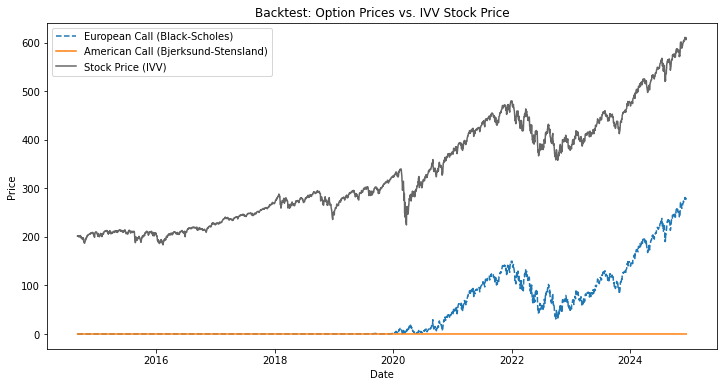

In [18]:
# === Plot Results ===
plt.figure(figsize=(12, 6))
plt.plot(equity_df.index, equity_df['BS_Call_Price'], label="European Call (Black-Scholes)", linestyle="dashed")
plt.plot(equity_df.index, equity_df['BS_American_Call'], label="American Call (Bjerksund-Stensland)", linestyle="solid")
plt.plot(equity_df.index, equity_df['Close'], label="Stock Price (IVV)", color="black", alpha=0.6)
plt.legend()
plt.title("Backtest: Option Prices vs. IVV Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()